# DDM² Stage 2: Noise Level Matching

**功能**: 使用老师的 N2N 去噪结果，计算每个样本的噪声水平，匹配到扩散模型的 timestep

**工作流程**:
1. 加载 simulation 噪声图像和 teacher N2N 去噪结果
2. 计算 noise_std = std(noisy - denoised)
3. 匹配到扩散模型的 timestep
4. 输出 stage2_matched.txt

---

## 1. 路径配置

In [1]:
import os
import sys
import json

# ==================== 路径配置 ====================

# DDM² 项目根目录
PROJECT_ROOT = '/host/c/Users/ROG/Documents/GitHub/DDM2'

# 配置文件路径（Stage 2 完成后会自动更新此文件）
CONFIG_FILE = 'config/ct_denoise.json'

# ================================================

os.chdir(PROJECT_ROOT)
sys.path.insert(0, PROJECT_ROOT)

config_path = os.path.join(PROJECT_ROOT, CONFIG_FILE)
with open(config_path, 'r') as f:
    config = json.load(f)

print(f"工作目录: {os.getcwd()}")
print(f"配置文件: {config_path}")
print(f"实验名称: {config.get('name', 'unknown')}")

工作目录: /host/c/Users/ROG/Documents/GitHub/DDM2
配置文件: /host/c/Users/ROG/Documents/GitHub/DDM2/config/ct_denoise.json
实验名称: ct_denoise_teacher


## 2. 数据路径配置

In [2]:
# ==================== 数据路径 ====================

# Excel 文件路径（包含所有样本信息）
DATAROOT = '/host/d/file/fixedCT_static_simulation_train_test_gaussian_local.xlsx'

# 原始数据根目录（simulation 文件夹，包含 nii.gz 文件）
DATA_ROOT = '/host/d/file/simulation/'

# NPY 缓存目录（加速数据加载）
# 如果为 None，则自动设为 DATA_ROOT 同级的 simulation_npy/
NPY_ROOT = None  # 或 '/host/d/file/simulation_npy/'

# Teacher N2N 预测结果目录（老师的 N2N 模型输出）
TEACHER_N2N_ROOT = '/host/d/file/pre/noise2noise/pred_images/'
TEACHER_N2N_EPOCH = 78

# Histogram equalization 文件
BINS_FILE = '/host/d/file/histogram_equalization/bins.npy'
BINS_MAPPED_FILE = '/host/d/file/histogram_equalization/bins_mapped.npy'

# ================================================

# 自动设置 NPY_ROOT
if NPY_ROOT is None:
    NPY_ROOT = DATA_ROOT.rstrip('/').replace('/simulation', '/simulation_npy') + '/'

print("数据路径配置:")
print(f"  Excel: {DATAROOT}")
print(f"  数据根目录 (simulation): {DATA_ROOT}")
print(f"  NPY 缓存目录: {NPY_ROOT}")
print(f"  Teacher N2N (老师的结果): {TEACHER_N2N_ROOT}")
print(f"  Teacher epoch: {TEACHER_N2N_EPOCH}")

数据路径配置:
  Excel: /host/d/file/fixedCT_static_simulation_train_test_gaussian_local.xlsx
  数据根目录 (simulation): /host/d/file/simulation/
  NPY 缓存目录: /host/d/file/simulation_npy/
  Teacher N2N (老师的结果): /host/d/file/pre/noise2noise/pred_images/
  Teacher epoch: 78


## 3. 数据选择配置

In [3]:
# ==================== 数据选择 ====================

# Batch 选择
# - Batch 0-4: 训练集 (84 pairs)
# - Batch 5: 验证集 (16 pairs)
TRAIN_BATCHES = [0, 1, 2, 3, 4]   # Stage 2 匹配 + Stage 3 训练
VAL_BATCHES = [5]                  # Stage 3 验证用

# Slice 范围 [start, end)
# 注意：要和 N2N 训练时用的范围一致
SLICE_START = 30
SLICE_END = 80

# random_num 选择
# 'both' = 两个噪声实现都用 (N2N 模式)
# 0 = 只用 random_num=0
# 1 = 只用 random_num=1
USE_RANDOM_NUM = 0

# ================================================

print("数据选择配置:")
print(f"  训练 batch (Stage 2 匹配): {TRAIN_BATCHES}")
print(f"  验证 batch (Stage 3 用): {VAL_BATCHES}")
print(f"  Slice 范围: [{SLICE_START}, {SLICE_END})")
print(f"  random_num: {USE_RANDOM_NUM}")

数据选择配置:
  训练 batch (Stage 2 匹配): [0, 1, 2, 3, 4]
  验证 batch (Stage 3 用): [5]
  Slice 范围: [30, 80)
  random_num: 0


## 4. 预处理配置

In [4]:
# ==================== 预处理配置 ====================

# HU 值范围
HU_MIN = -1000.0
HU_MAX = 2000.0

# Histogram equalization
HISTOGRAM_EQUALIZATION = True

# 图像尺寸
IMAGE_SIZE = 512

# Padding (用于 condition 的相邻 slice 数量)
PADDING = 3

# 数据增强（训练时）
LR_FLIP = 0.5

# ================================================

print("预处理配置:")
print(f"  HU 范围: [{HU_MIN}, {HU_MAX}]")
print(f"  Histogram equalization: {HISTOGRAM_EQUALIZATION}")
print(f"  图像尺寸: {IMAGE_SIZE}")
print(f"  Padding: {PADDING}")

预处理配置:
  HU 范围: [-1000.0, 2000.0]
  Histogram equalization: True
  图像尺寸: 512
  Padding: 3


## 5. 更新 Config

In [5]:
# 将配置写入 config 字典
for phase in ['train', 'val']:
    config['datasets'][phase]['dataroot'] = DATAROOT
    config['datasets'][phase]['data_root'] = DATA_ROOT
    config['datasets'][phase]['train_batches'] = TRAIN_BATCHES
    config['datasets'][phase]['val_batches'] = VAL_BATCHES
    config['datasets'][phase]['valid_mask'] = [0, 1000]  # 不限制 pair 数量
    config['datasets'][phase]['slice_range'] = [SLICE_START, SLICE_END]
    config['datasets'][phase]['use_random_num'] = USE_RANDOM_NUM
    config['datasets'][phase]['HU_MIN'] = HU_MIN
    config['datasets'][phase]['HU_MAX'] = HU_MAX
    config['datasets'][phase]['histogram_equalization'] = HISTOGRAM_EQUALIZATION
    config['datasets'][phase]['bins_file'] = BINS_FILE
    config['datasets'][phase]['bins_mapped_file'] = BINS_MAPPED_FILE
    config['datasets'][phase]['teacher_n2n_root'] = TEACHER_N2N_ROOT
    config['datasets'][phase]['teacher_n2n_epoch'] = TEACHER_N2N_EPOCH
    config['datasets'][phase]['image_size'] = IMAGE_SIZE
    config['datasets'][phase]['padding'] = PADDING
    config['datasets'][phase]['lr_flip'] = LR_FLIP if phase == 'train' else 0.0

# Stage 2 匹配时用 'all' volumes 和 slices
config['datasets']['val']['val_volume_idx'] = 'all'
config['datasets']['val']['val_slice_idx'] = 'all'

print("✓ Config 已更新")

✓ Config 已更新


## 6. 检查依赖

In [6]:
import glob

print("=" * 60)
print("Stage 2 依赖检查")
print("=" * 60)

all_ok = True

# 1. Excel 文件
print(f"\n[Excel 文件]")
print(f"  路径: {DATAROOT}")
excel_exists = os.path.exists(DATAROOT)
print(f"  状态: {'✓' if excel_exists else '✗ 不存在!'}")
if not excel_exists:
    all_ok = False

# 2. 数据目录
print(f"\n[Simulation 数据目录]")
print(f"  路径: {DATA_ROOT}")
data_exists = os.path.exists(DATA_ROOT)
print(f"  状态: {'✓' if data_exists else '✗ 不存在!'}")
if not data_exists:
    all_ok = False

# 3. Teacher N2N（老师的 N2N 结果，不是自己训练的）
print(f"\n[Teacher N2N (老师的 N2N 去噪结果)]")
print(f"  路径: {TEACHER_N2N_ROOT}")
teacher_exists = os.path.exists(TEACHER_N2N_ROOT)
print(f"  状态: {'✓' if teacher_exists else '✗ 不存在!'}")
if not teacher_exists:
    all_ok = False

# 4. Histogram equalization
if HISTOGRAM_EQUALIZATION:
    print(f"\n[Histogram Equalization]")
    bins_exists = os.path.exists(BINS_FILE)
    bins_mapped_exists = os.path.exists(BINS_MAPPED_FILE)
    print(f"  bins: {'✓' if bins_exists else '✗'} {BINS_FILE}")
    print(f"  bins_mapped: {'✓' if bins_mapped_exists else '✗'} {BINS_MAPPED_FILE}")
    if not (bins_exists and bins_mapped_exists):
        all_ok = False

# 5. Beta schedule (用于匹配 timestep)
beta = config.get('model', {}).get('beta_schedule', {}).get('train', {})
print(f"\n[Beta Schedule]")
print(f"  schedule: {beta.get('schedule')}")
print(f"  n_timestep: {beta.get('n_timestep')}")

# 6. 实验目录（从 config 读取正确的名称）
exp_name = config.get('name', 'ct_denoise')
exp_dir = os.path.join('experiments', exp_name)
print(f"\n[实验目录]")
print(f"  名称: {exp_name}")
print(f"  路径: {exp_dir}")
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir, exist_ok=True)
    print(f"  状态: ✓ 已创建")
else:
    print(f"  状态: ✓ 已存在")

print("\n" + "=" * 60)
if all_ok:
    print("✓ 所有依赖检查通过！")
else:
    print("✗ 请修复上述问题后再运行")
print("=" * 60)

Stage 2 依赖检查

[Excel 文件]
  路径: /host/d/file/fixedCT_static_simulation_train_test_gaussian_local.xlsx
  状态: ✓

[Simulation 数据目录]
  路径: /host/d/file/simulation/
  状态: ✓

[Teacher N2N (老师的 N2N 去噪结果)]
  路径: /host/d/file/pre/noise2noise/pred_images/
  状态: ✓

[Histogram Equalization]
  bins: ✓ /host/d/file/histogram_equalization/bins.npy
  bins_mapped: ✓ /host/d/file/histogram_equalization/bins_mapped.npy

[Beta Schedule]
  schedule: rev_warmup70
  n_timestep: 1000

[实验目录]
  名称: ct_denoise_teacher
  路径: experiments/ct_denoise_teacher
  状态: ✓ 已创建

✓ 所有依赖检查通过！


## 7. 检查/转换 NPY 缓存

将 `.nii.gz` 文件转换为 `.npy` 格式可以大幅加速数据加载（约 10-50 倍）

In [7]:
import pandas as pd
import numpy as np

def get_npy_path(nii_path, data_root, npy_root):
    """将 nii.gz 路径转换为 npy 路径"""
    rel_path = nii_path.replace(data_root, '').lstrip('/')
    npy_path = os.path.join(npy_root, rel_path.replace('.nii.gz', '.npy'))
    return npy_path

def check_npy_status(excel_path, data_root, npy_root, batches, use_random_num='both'):
    """检查 simulation 数据的 npy 文件状态"""
    df = pd.read_excel(excel_path)
    df = df[df['batch'].isin(batches)]
    
    # 收集所有需要的文件
    if use_random_num == 'both':
        files_to_check = df['noise_file'].tolist()
    elif use_random_num == 0:
        files_to_check = df[df['random_num'] == 0]['noise_file'].tolist()
    elif use_random_num == 1:
        files_to_check = df[df['random_num'] == 1]['noise_file'].tolist()
    
    missing_npy = []
    existing_npy = []
    
    for nii_path in files_to_check:
        nii_path = nii_path.replace('/host/d/file/simulation/', data_root)
        npy_path = get_npy_path(nii_path, data_root, npy_root)
        
        if os.path.exists(npy_path):
            existing_npy.append(npy_path)
        else:
            missing_npy.append((nii_path, npy_path))
    
    return existing_npy, missing_npy

# 只检查训练集（Stage 2 只匹配训练数据）
print("=" * 60)
print("检查 NPY 缓存状态 (Simulation 训练数据)")
print("=" * 60)

existing_sim, missing_sim = check_npy_status(
    DATAROOT, DATA_ROOT, NPY_ROOT, 
    TRAIN_BATCHES,  # 只检查训练集
    USE_RANDOM_NUM
)

print(f"\nSimulation 训练数据 (batch {TRAIN_BATCHES}):")
print(f"  已有 NPY: {len(existing_sim)} 个")
print(f"  缺少 NPY: {len(missing_sim)} 个")

if missing_sim:
    print(f"\n⚠ 有 {len(missing_sim)} 个文件需要转换为 NPY")
    print(f"  示例: {missing_sim[0][0]}")
else:
    print(f"\n✓ 所有 Simulation 训练数据已有 NPY 缓存")

检查 NPY 缓存状态 (Simulation 训练数据)

Simulation 训练数据 (batch [0, 1, 2, 3, 4]):
  已有 NPY: 84 个
  缺少 NPY: 0 个

✓ 所有 Simulation 训练数据已有 NPY 缓存


In [8]:
# 检查 Teacher N2N 数据（只检查训练集）
def check_teacher_npy_status(excel_path, teacher_root, teacher_epoch, batches):
    """检查 teacher N2N 的 npy 状态"""
    df = pd.read_excel(excel_path)
    df = df[df['batch'].isin(batches)]
    
    # 获取唯一的 patient 组合
    patients = df.groupby(['Patient_ID', 'Patient_subID']).first().reset_index()
    
    missing = []
    existing = []
    not_found = []  # nii.gz 也不存在的
    
    for _, row in patients.iterrows():
        pid = f"{int(row['Patient_ID']):08d}"
        psid = f"{int(row['Patient_subID']):010d}"
        
        pred_path = os.path.join(
            teacher_root, pid, psid, "random_0",
            f"epoch{teacher_epoch}", "pred_img.nii.gz"
        )
        npy_path = pred_path.replace('.nii.gz', '.npy')
        
        if os.path.exists(npy_path):
            existing.append(npy_path)
        elif os.path.exists(pred_path):
            missing.append((pred_path, npy_path))
        else:
            not_found.append(pred_path)
    
    return existing, missing, not_found

print("\n" + "=" * 60)
print("检查 NPY 缓存状态 (Teacher N2N 训练数据)")
print("=" * 60)

existing_teacher, missing_teacher, not_found_teacher = check_teacher_npy_status(
    DATAROOT, TEACHER_N2N_ROOT, TEACHER_N2N_EPOCH,
    TRAIN_BATCHES  # 只检查训练集
)

print(f"\nTeacher N2N 训练数据 (batch {TRAIN_BATCHES}):")
print(f"  已有 NPY: {len(existing_teacher)} 个")
print(f"  缺少 NPY (有 nii.gz): {len(missing_teacher)} 个")
print(f"  完全不存在: {len(not_found_teacher)} 个")

if not_found_teacher:
    print(f"\n⚠ 警告: 有 {len(not_found_teacher)} 个 patient 没有 teacher N2N 结果!")
    print(f"  示例: {not_found_teacher[0]}")
    print(f"  这些 patient 将被跳过")

if missing_teacher:
    print(f"\n需要转换 {len(missing_teacher)} 个 teacher N2N 文件")
else:
    print(f"\n✓ 所有已有的 Teacher N2N 数据已有 NPY 缓存")


检查 NPY 缓存状态 (Teacher N2N 训练数据)

Teacher N2N 训练数据 (batch [0, 1, 2, 3, 4]):
  已有 NPY: 84 个
  缺少 NPY (有 nii.gz): 0 个
  完全不存在: 0 个

✓ 所有已有的 Teacher N2N 数据已有 NPY 缓存


### 7.1 转换 NII.GZ 到 NPY（如果需要）

In [9]:
import nibabel as nib
from tqdm import tqdm

def convert_nii_to_npy(nii_path, npy_path, verbose=False):
    """将单个 nii.gz 文件转换为 npy"""
    try:
        os.makedirs(os.path.dirname(npy_path), exist_ok=True)
        nii = nib.load(nii_path)
        data = nii.get_fdata().astype(np.float32)
        np.save(npy_path, data)
        
        if verbose:
            print(f"✓ {os.path.basename(nii_path)} -> shape: {data.shape}")
        return True
    except Exception as e:
        print(f"✗ 转换失败: {nii_path} - {e}")
        return False

# 合并所有需要转换的文件
all_missing = missing_sim + missing_teacher

if all_missing:
    print(f"\n总共需要转换 {len(all_missing)} 个文件")
    print(f"  Simulation: {len(missing_sim)}")
    print(f"  Teacher N2N: {len(missing_teacher)}")
    print("\n运行下一个 cell 开始转换...")
else:
    print("\n✓ 所有文件已有 NPY 缓存，无需转换")


✓ 所有文件已有 NPY 缓存，无需转换


In [10]:
# ==================== 执行转换 ====================
# 如果不需要转换，可以跳过此 cell

if all_missing:
    print(f"开始转换 {len(all_missing)} 个文件...")
    print("=" * 60)
    
    success = 0
    failed = 0
    
    for nii_path, npy_path in tqdm(all_missing, desc="转换进度"):
        if convert_nii_to_npy(nii_path, npy_path, verbose=False):
            success += 1
        else:
            failed += 1
    
    print("\n" + "=" * 60)
    print(f"转换完成: 成功 {success}, 失败 {failed}")
    print("=" * 60)
else:
    print("无需转换")

无需转换


## 8. 数据量预览

In [11]:
if os.path.exists(DATAROOT):
    df = pd.read_excel(DATAROOT)
    
    # 训练集（Stage 2 匹配用）
    train_df = df[df['batch'].isin(TRAIN_BATCHES)]
    grouped_train = train_df.groupby(['Patient_ID', 'Patient_subID'])
    
    if USE_RANDOM_NUM == 'both':
        n_pairs_train = sum(1 for _, g in grouped_train if len(g) >= 2)
    else:
        filtered = train_df[train_df['random_num'] == USE_RANDOM_NUM]
        n_pairs_train = len(filtered.groupby(['Patient_ID', 'Patient_subID']))
    
    # 验证集（Stage 3 用）
    val_df = df[df['batch'].isin(VAL_BATCHES)]
    grouped_val = val_df.groupby(['Patient_ID', 'Patient_subID'])
    
    if USE_RANDOM_NUM == 'both':
        n_pairs_val = sum(1 for _, g in grouped_val if len(g) >= 2)
    else:
        filtered = val_df[val_df['random_num'] == USE_RANDOM_NUM]
        n_pairs_val = len(filtered.groupby(['Patient_ID', 'Patient_subID']))
    
    n_slices = SLICE_END - SLICE_START
    
    # 实际可用的 pairs（有  N2N 结果的）
    n_pairs_with_teacher = len(existing_teacher) + len(missing_teacher)
    
    print("=" * 60)
    print("数据量统计")
    print("=" * 60)
    print(f"\n训练集 (batch {TRAIN_BATCHES}):")
    print(f"  N2N pairs: {n_pairs_train}")
    print(f"  有 teacher N2N: {n_pairs_with_teacher}")
    print(f"  Slices per volume: {n_slices}")
    print(f"  Stage 2 匹配样本数: {n_pairs_with_teacher * n_slices}")
    
    print(f"\n验证集 (batch {VAL_BATCHES}):")
    print(f"  N2N pairs: {n_pairs_val}")
    
    if not_found_teacher:
        print(f"\n⚠ 注意: {len(not_found_teacher)} 个训练 patient 没有 teacher N2N 结果")
    
    print("=" * 60)
else:
    print(f"Excel 不存在: {DATAROOT}")

数据量统计

训练集 (batch [0, 1, 2, 3, 4]):
  N2N pairs: 84
  有 teacher N2N: 84
  Slices per volume: 50
  Stage 2 匹配样本数: 4200

验证集 (batch [5]):
  N2N pairs: 16


## 9. 运行 Stage 2

⚠️ **重要**: 请确保按顺序运行前面的 cell，否则配置可能不正确

In [12]:
import subprocess

# ==================== 重新读取配置，确保使用正确的实验名称 ====================
with open(config_path, 'r') as f:
    config_for_run = json.load(f)

# 获取实验名称
exp_name = config.get('name', config_for_run.get('name', 'ct_denoise'))
exp_dir = os.path.join('experiments', exp_name)

# 确保实验目录存在
os.makedirs(exp_dir, exist_ok=True)
print(f"✓ 实验目录已准备: {exp_dir}")

# 确保 config 目录存在
os.makedirs('config', exist_ok=True)

# 保存临时配置
temp_config = os.path.join(PROJECT_ROOT, 'config', '_stage2_temp.json')
with open(temp_config, 'w') as f:
    json.dump(config, f, indent=4)
print(f"✓ 临时配置已保存: {temp_config}")

# 构建命令
cmd = f"python match_state.py -p train -c {temp_config}"
print(f"\n执行: {cmd}")
print("=" * 60)

# 运行 Stage 2
process = subprocess.Popen(
    cmd, shell=True,
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
    text=True, bufsize=1
)
for line in process.stdout:
    print(line, end='')
process.wait()

print("\n" + "=" * 60)
print(f"返回码: {process.returncode}")

# 清理临时配置
if os.path.exists(temp_config):
    os.remove(temp_config)
    print("✓ 临时配置已清理")

✓ 实验目录已准备: experiments/ct_denoise_teacher
✓ 临时配置已保存: /host/c/Users/ROG/Documents/GitHub/DDM2/config/_stage2_temp.json

执行: python match_state.py -p train -c /host/c/Users/ROG/Documents/GitHub/DDM2/config/_stage2_temp.json
export CUDA_VISIBLE_DEVICES=0
26-01-02 20:01:57.155 - INFO: [Stage 2] Markov chain state matching (using teacher N2N)!
[train] Histogram equalization enabled
[DEBUG] Phase: train, target_batches: [0, 1, 2, 3, 4]
[DEBUG] Original df rows: 200
[DEBUG] After batch filter: 168 rows
[DEBUG] _build_n2n_pairs: df has 168 rows, 84 groups
[DEBUG] use_random_num = both
Found 69 N2N pairs (skipped 15 bad samples)
[WARNING] Detected offset (50) != config slice_start (30)
[train] val_volume_idx: [0, 1, 2, 3, 4]... (total 69)
[train] val_slice_idx: [0, 1, 2, 3, 4]... (total 50)
[train] n2n_pairs: 69, num_slices: 50
[DEBUG] _build_sample_indices: phase=train
[DEBUG] n2n_pairs=69, num_slices=50
[DEBUG] val_volume_idx=[0, 1, 2, 3, 4]...
[DEBUG] val_slice_idx=[0, 1, 2, 3, 4]...
[DEBUG]

## 10. 自动更新 Config

In [13]:
# 查找 stage2_matched.txt
stage2_file = None

# 方法1: 从实验目录查找
exp_name = config.get('name', 'ct_denoise')
candidate = os.path.join('experiments', exp_name, 'stage2_matched.txt')
if os.path.exists(candidate):
    stage2_file = candidate

# 方法2: 从最新实验目录查找
if not stage2_file:
    exp_dirs = sorted(glob.glob('experiments/*'), key=os.path.getmtime, reverse=True)
    for exp_dir in exp_dirs:
        candidate = os.path.join(exp_dir, 'stage2_matched.txt')
        if os.path.exists(candidate):
            stage2_file = candidate
            break

# 方法3: 根目录
if not stage2_file and os.path.exists('stage2_matched.txt'):
    stage2_file = 'stage2_matched.txt'

if stage2_file:
    print(f"找到 Stage 2 输出: {stage2_file}")
    
    # 统计
    with open(stage2_file, 'r') as f:
        lines = f.readlines()
    matched_ts = [int(l.strip().split('_')[-1]) for l in lines if l.strip()]
    
    print(f"样本数: {len(lines)}")
    print(f"matched_t: mean={np.mean(matched_ts):.1f}, range=[{min(matched_ts)}, {max(matched_ts)}]")
    
    # ========== 自动更新 config ==========
    with open(config_path, 'r') as f:
        original_config = json.load(f)
    
    # 更新 stage2_file
    original_config['stage2_file'] = stage2_file
    
    # 更新数据配置（保存当前设置供 Stage 3 使用）
    for phase in ['train', 'val']:
        original_config['datasets'][phase]['dataroot'] = DATAROOT
        original_config['datasets'][phase]['data_root'] = DATA_ROOT
        original_config['datasets'][phase]['train_batches'] = TRAIN_BATCHES
        original_config['datasets'][phase]['val_batches'] = VAL_BATCHES
        original_config['datasets'][phase]['valid_mask'] = [0, 1000]
        original_config['datasets'][phase]['slice_range'] = [SLICE_START, SLICE_END]
        original_config['datasets'][phase]['use_random_num'] = USE_RANDOM_NUM
        original_config['datasets'][phase]['HU_MIN'] = HU_MIN
        original_config['datasets'][phase]['HU_MAX'] = HU_MAX
        original_config['datasets'][phase]['histogram_equalization'] = HISTOGRAM_EQUALIZATION
        original_config['datasets'][phase]['bins_file'] = BINS_FILE
        original_config['datasets'][phase]['bins_mapped_file'] = BINS_MAPPED_FILE
        original_config['datasets'][phase]['teacher_n2n_root'] = TEACHER_N2N_ROOT
        original_config['datasets'][phase]['teacher_n2n_epoch'] = TEACHER_N2N_EPOCH
    
    with open(config_path, 'w') as f:
        json.dump(original_config, f, indent=4)
    
    print(f"\n✓ 已自动更新 {CONFIG_FILE}:")
    print(f'  "stage2_file": "{stage2_file}"')
    print(f"\n→ Stage 3 可以直接运行")
else:
    print("✗ 未找到 stage2_matched.txt")

找到 Stage 2 输出: experiments/ct_denoise_teacher/stage2_matched.txt
样本数: 3450
matched_t: mean=33.5, range=[17, 68]

✓ 已自动更新 config/ct_denoise.json:
  "stage2_file": "experiments/ct_denoise_teacher/stage2_matched.txt"

→ Stage 3 可以直接运行


## 11. 可视化 matched_t 分布

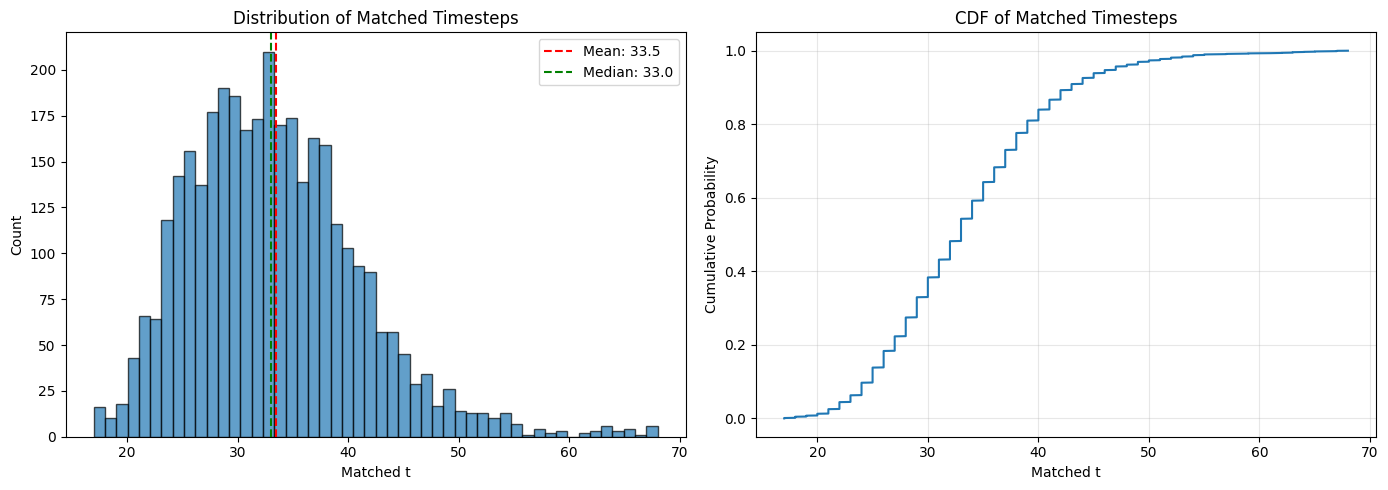


统计信息:
  样本数: 3450
  Mean: 33.48
  Std: 7.59
  Min: 17
  Max: 68


In [14]:
import matplotlib.pyplot as plt

if 'matched_ts' in dir() and matched_ts:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 直方图
    axes[0].hist(matched_ts, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(matched_ts), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(matched_ts):.1f}')
    axes[0].axvline(np.median(matched_ts), color='g', linestyle='--',
                   label=f'Median: {np.median(matched_ts):.1f}')
    axes[0].set_xlabel('Matched t')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribution of Matched Timesteps')
    axes[0].legend()
    
    # 累积分布
    sorted_ts = np.sort(matched_ts)
    cdf = np.arange(1, len(sorted_ts) + 1) / len(sorted_ts)
    axes[1].plot(sorted_ts, cdf)
    axes[1].set_xlabel('Matched t')
    axes[1].set_ylabel('Cumulative Probability')
    axes[1].set_title('CDF of Matched Timesteps')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 统计信息
    print(f"\n统计信息:")
    print(f"  样本数: {len(matched_ts)}")
    print(f"  Mean: {np.mean(matched_ts):.2f}")
    print(f"  Std: {np.std(matched_ts):.2f}")
    print(f"  Min: {min(matched_ts)}")
    print(f"  Max: {max(matched_ts)}")

---

## 配置总结

In [15]:
print("=" * 60)
print("当前配置总结")
print("=" * 60)
print(f"""
路径配置:
  PROJECT_ROOT = '{PROJECT_ROOT}'
  DATAROOT = '{DATAROOT}'
  DATA_ROOT = '{DATA_ROOT}'
  NPY_ROOT = '{NPY_ROOT}'
  TEACHER_N2N_ROOT = '{TEACHER_N2N_ROOT}'
  TEACHER_N2N_EPOCH = {TEACHER_N2N_EPOCH}

数据选择:
  TRAIN_BATCHES = {TRAIN_BATCHES}  ← Stage 2 匹配这些
  VAL_BATCHES = {VAL_BATCHES}       ← Stage 3 验证用
  SLICE_RANGE = [{SLICE_START}, {SLICE_END})
  USE_RANDOM_NUM = '{USE_RANDOM_NUM}'

预处理:
  HU_RANGE = [{HU_MIN}, {HU_MAX}]
  HISTOGRAM_EQUALIZATION = {HISTOGRAM_EQUALIZATION}
""")
print("=" * 60)

当前配置总结

路径配置:
  PROJECT_ROOT = '/host/c/Users/ROG/Documents/GitHub/DDM2'
  DATAROOT = '/host/d/file/fixedCT_static_simulation_train_test_gaussian_local.xlsx'
  DATA_ROOT = '/host/d/file/simulation/'
  NPY_ROOT = '/host/d/file/simulation_npy/'
  TEACHER_N2N_ROOT = '/host/d/file/pre/noise2noise/pred_images/'
  TEACHER_N2N_EPOCH = 78

数据选择:
  TRAIN_BATCHES = [0, 1, 2, 3, 4]  ← Stage 2 匹配这些
  VAL_BATCHES = [5]       ← Stage 3 验证用
  SLICE_RANGE = [30, 80)
  USE_RANDOM_NUM = '0'

预处理:
  HU_RANGE = [-1000.0, 2000.0]
  HISTOGRAM_EQUALIZATION = True



---

## 下一步

Config 已自动更新，直接运行 `2_train/train_ddm2.ipynb`。